In [3]:
pip install transformers

     |████████████████████████████████| 2.5MB 9.6MB/s 
     |████████████████████████████████| 3.3MB 42.6MB/s 
     |████████████████████████████████| 901kB 46.4MB/s 


In [4]:
###### Imports ######

# unsupervised label generation
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# sentiment analysis tools
import transformers
from transformers import BertForSequenceClassification, BertTokenizer, AdamW, get_linear_schedule_with_warmup, \
    TrainingArguments, Trainer, BertConfig
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [62]:

###### Load Data ######
df = pd.read_csv("./B2_P4.csv",
                 header=None,
                 names=['index', 'title', 'author', 'publisher', 'date', 'text'])

print(df.head())
print(df.columns)
print(f'shape: {df.shape}')

#X_train, X_test = train_test_split(df.copy(), test_size=0.2, random_state=21, shuffle=True)
#X_val, X_test = train_test_split(X_test.copy(), test_size=0.5, random_state=22, shuffle=True)

X_train=df[0:100]

# steps:
# 1. generate labels for X_train
# 2. build BERT model
# 3. training
# 4. predictions


   index  ...                                               text
0  index  ...                                               text
1      0  ...   royal arms of england circa honi sot qvi mal ...
2      1  ...   honi solt qvi mal y pens diev et mon droit by...
3      2  ...   royal arms of england circa diev et mon droit...
4      3  ...   royal arms of england circa no qvi mal se die...

[5 rows x 6 columns]
Index(['index', 'title', 'author', 'publisher', 'date', 'text'], dtype='object')
shape: (2043, 6)


In [63]:

analyzer = SentimentIntensityAnalyzer()


In [18]:
#internet vader sentiment definition 1
def vader_sentiment_result(sent):
    scores = analyzer.polarity_scores(sent)

    if scores["neg"] >= max(scores["pos"],scores['neu']):
        return 0
    elif scores['neu'] >= max(scores['pos'],scores['neg']):
        return 1

    return 2


In [64]:

#internet vader sentiment definition 2
def vader_sentiment_result(sent):
    scores = analyzer.polarity_scores(sent)

    if scores["compound"] <=-0.5:
        return 0
    elif scores["compound"] >= 0.5:
        return 2

    return 1



In [65]:

X_train["vader_result"] = X_train['title'].apply(lambda x: vader_sentiment_result(x))
#X_val["vader_result"] = X_val['title'].apply(lambda x: vader_sentiment_result(x))

print(X_train['vader_result'].value_counts())

print(X_train.loc[0:100,['title', 'vader_result']])
#print(X_train['vader_result'])
# neutral with what Vader suggested results with Vader and issues:
# 1 6945
# 2 51
# 0 6
# we need to filter out the unncessary stuff in the titles, clean spelling, find a good way to determine postive, negative, neutral with Vader

# 1    3409
# 2    2248
# 0    1345


1    55
2    40
0     5
Name: vader_result, dtype: int64
                                                title  vader_result
0                                               title             1
1   by the king a proclamation prohibiting the imp...             1
2   by the king a proclamation prohibiting the imp...             2
3   by the king a proclamation prohibiting the imp...             1
4   by the king a proclamation prohibiting the kee...             1
..                                                ...           ...
95    considerations about the transportation of wool             1
96  considerations concerning ireland in relation ...             2
97  considerations humbly offered to the honourabl...             1
98  considerations humbly offered to the honourabl...             2
99  considerations humbly offered to the lords spi...             1

[100 rows x 2 columns]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


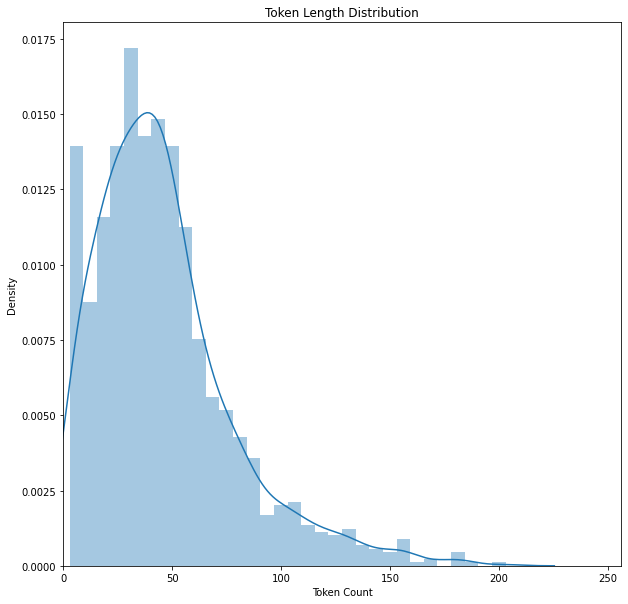

In [35]:

###### Build Dataset ######

# sentiment analysis stuff

pretrained_model_name = 'bert-base-uncased'

tokenizer = BertTokenizer.from_pretrained(pretrained_model_name)
token_lens = []
for txt in df.title:
    tokens = tokenizer.encode(txt,max_length=512)
    token_lens.append(len(tokens))

fig = plt.figure(figsize = (10,10))
sns.distplot(token_lens)
plt.title('Token Length Distribution')
plt.xlim([0,256])
plt.xlabel('Token Count')
plt.show()





In [ ]:
'''  
max_len=200

class SentimentAnalysisDataset(Dataset):
    def __init__(self, titles, targets, tokenizer, max_len):
        self.titles = titles
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.titles)

    def __getitem__(self, item):
        title = str(self.titles[item])
        target = self.targets[item]
        encoding = self.tokenizer.encode_plus(
            title,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
              'title_text': title,
              'input_ids': encoding['input_ids'][0],
              'attention_mask': encoding['attention_mask'][0],
              'labels': torch.tensor(target, dtype=torch.long)
          }
'''

In [ ]:
'''
X_train_ds = SentimentAnalysisDataset(titles=X_train['title'].tolist(),
                                      targets=X_train['vader_result'].tolist(),
                                      tokenizer=tokenizer,
                                      max_len=max_len)

X_val_ds = SentimentAnalysisDataset(titles=X_val['title'].tolist(),
                                    targets=X_val['vader_result'].tolist(),
                                    tokenizer=tokenizer,
                                    max_len=max_len)

config = BertConfig.from_pretrained(pretrained_model_name)
config.num_labels = 3

model= BertForSequenceClassification(config)
'''


loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.8.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [ ]:

'''
for name, param in model.bert.named_parameters():
    if (not name.startswith('pooler')) and "layer.23" not in name:
        param.requires_grad=False
'''


In [41]:

'''
def compute_metrics(pred):
    labels=pred.label_ids
    preds= pred.predictions.argmax(-1)
    precision, recall, f1, _ =precision_recall_fscore_support(labels, preds, average='weighted')
    acc=accuracy_score(labels,preds)
    return {'accucracy': acc, 'f1':f1, 'precision': precision, 'recall': recall}
'''



In [51]:

training_args=TrainingArguments(
    output_dir = './BERT_output',
    num_train_epochs=20,
    per_device_train_batch_size=16,
    per_device_eval_batch_size= 64,
    warmup_steps= 500,
    weight_decay= 0.01,
    save_strategy= "epoch",
    evaluation_strategy= "steps"
)

trainer= Trainer(
    model= model,
    args= training_args,
    train_dataset= X_train_ds,
    eval_dataset= None,
    compute_metrics= compute_metrics
)


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
#trainer.train()

***** Running training *****
  Num examples = 1634
  Num Epochs = 20
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2060


Step,Training Loss,Validation Loss,Accucracy,F1,Precision,Recall
500,0.176000,0.087067,0.985294,0.977996,0.970804,0.985294
1000,0.050800,0.096297,0.985294,0.977996,0.970804,0.985294
1500,0.052200,0.083268,0.985294,0.977996,0.970804,0.985294
2000,0.050500,0.081718,0.985294,0.977996,0.970804,0.985294


Saving model checkpoint to ./BERT_output/checkpoint-103
Configuration saved in ./BERT_output/checkpoint-103/config.json
Model weights saved in ./BERT_output/checkpoint-103/pytorch_model.bin
Saving model checkpoint to ./BERT_output/checkpoint-206
Configuration saved in ./BERT_output/checkpoint-206/config.json
Model weights saved in ./BERT_output/checkpoint-206/pytorch_model.bin
Saving model checkpoint to ./BERT_output/checkpoint-309
Configuration saved in ./BERT_output/checkpoint-309/config.json
Model weights saved in ./BERT_output/checkpoint-309/pytorch_model.bin
Saving model checkpoint to ./BERT_output/checkpoint-412
Configuration saved in ./BERT_output/checkpoint-412/config.json
Model weights saved in ./BERT_output/checkpoint-412/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 204
  Batch size = 64
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labe

TrainOutput(global_step=2060, training_loss=0.08125745196944302, metrics={'train_runtime': 510.9855, 'train_samples_per_second': 63.955, 'train_steps_per_second': 4.031, 'total_flos': 4293545995152000.0, 'train_loss': 0.08125745196944302, 'epoch': 20.0})

In [52]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.8.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/tra

In [53]:

max_len=200
class SentimentAnalysisDataset(Dataset):
    def __init__(self, titles, targets, tokenizer, max_len):
        self.titles = titles
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.titles)

    def __getitem__(self, item):
        title = str(self.titles[item])
        if self.targets is not None:
          target = self.targets[item]
        target = None
        encoding = self.tokenizer.encode_plus(
            title,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        if target is not None:

          return {
              'title_text': title,
              'input_ids': encoding['input_ids'][0],
              'attention_mask': encoding['attention_mask'][0],
              'labels': torch.tensor(target, dtype=torch.long)
          }
        
        return {
              'title_text': title,
              'input_ids': encoding['input_ids'][0],
              'attention_mask': encoding['attention_mask'][0],
              'labels': None
          }

In [54]:
X_train_ds = SentimentAnalysisDataset(titles = X_train['title'].tolist(),
                                     targets = None,
                                     tokenizer = tokenizer,
                                     max_len = max_len)


In [55]:
training_args = TrainingArguments(
    output_dir = './BERT_output',
    do_predict = True
)

train = Trainer(
    model = model,
    args = training_args,
    compute_metrics = compute_metrics
)


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [56]:
y_pred = trainer.predict(X_train_ds)

***** Running Prediction *****
  Num examples = 200
  Batch size = 64


In [57]:
preds = y_pred.predictions

np.argmax(preds,axis=1)

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [66]:
X_train

,index,title,author,publisher,date,text,vader_result
0,index,title,author,publisher,date,text,1
1,0,by the king a proclamation prohibiting the imp...,charles king of england -,printed by the assigns of john bill and christ...,['1666'],royal arms of england circa honi sot qvi mal ...,1
2,1,by the king a proclamation prohibiting the imp...,charles king of england -,printed by the assigns of john bill and christ...,['1666'],honi solt qvi mal y pens diev et mon droit by...,2
3,2,by the king a proclamation prohibiting the imp...,charles king of england -,printed by the assigns of john bill and christ...,['1669'],royal arms of england circa diev et mon droit...,1
4,3,by the king a proclamation prohibiting the kee...,charles king of england -,printed by john bill and christopher barker pr...,['1665'],royal arms of england circa no qvi mal se die...,1
...,...,...,...,...,...,...,...
95,94,considerations about the transportation of wool,no author,sn,['1696'],considerations about the transportation of wo...,1
96,95,considerations concerning ireland in relation ...,no author,sn,['1690'],considerations concerning ireland in relation...,2
97,96,considerations humbly offered to the honourabl...,no author,sn,['1697'],considerations humbly offered to the honourab...,1
98,97,considerations humbly offered to the honourabl...,no author,sn,['1700'],considerations humbly offered to the honourab...,2


In [59]:
predicted = pd.DataFrame()

predicted['title'] = X_train['title'].copy()
predicted['prediction'] = np.argmax(preds,axis=1)


predicted

,title,prediction
0,title,1
1,by the king a proclamation prohibiting the imp...,0
2,by the king a proclamation prohibiting the imp...,0
3,by the king a proclamation prohibiting the imp...,0
4,by the king a proclamation prohibiting the kee...,0
...,...,...
195,the loyal conquest or destruction of treason a...,0
196,the deceived virgin or the treacherous young l...,0
197,the declaration of the free and well-affected ...,0
198,the declaration of the gentry of the king's pa...,0


In [60]:
predicted[predicted.index == 1863]['title']

Series([], Name: title, dtype: object)